In [1]:
!pip install librosa
import numpy as np
import matplotlib.pyplot as plt
import glob
import librosa
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# The following lines allows to exploit the GPU and make the training faster (Check in the Runtime - Change Runtime time if the GPU is set)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[]

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
!ls
%cd /content/drive/MyDrive/Tesi/RAVDESS
audio_folder = '/content/drive/MyDrive/Tesi/RAVDESS/Actor_24/*.wav'

drive  sample_data
/content/drive/MyDrive/Tesi/RAVDESS


In [5]:
#Modality (01: full-AV, 02: video-only, 03: audio-only).
#Vocal channel (01: speech, 02: song).
#Emotion (01: neutral, 02: calm, 03: happy, 04: sad, 05: angry, 06: fearful, 07: disgust, 08: surprised).
#Emotional intensity (01: normal, 02: strong). NOTE: There is no strong intensity for the 'neutral' emotion.
#Statement (01: "Kids are talking by the door", 02: "Dogs are sitting by the door").
#Repetition (01: 1st repetition, 02: 2nd repetition).
#Actor (01 to 24. Odd-numbered actors are male, even-numbered actors are female).

# Retrieve a list of .wav files path in the folder
audio_files = glob.glob(audio_folder)
print(type(audio_files))

<class 'list'>


In [6]:
# Iterate through the audio files and load them
for audio_path in audio_files:
    audio, sr = librosa.load(audio_path)

In [7]:
#Retrieve the curret path directory
current_dir = os.getcwd()
print("Directory corrente:", current_dir)

Directory corrente: /content/drive/MyDrive/Tesi/RAVDESS


In [8]:
# We'll need IPython.display's Audio widget
from IPython.display import Audio

#An audio example: audio in an audio time series(np.ndarray)
#and sr is the sampling rate(scalar)
audio, sr = librosa.load(audio_files[10])
Audio(data = audio, rate = sr)

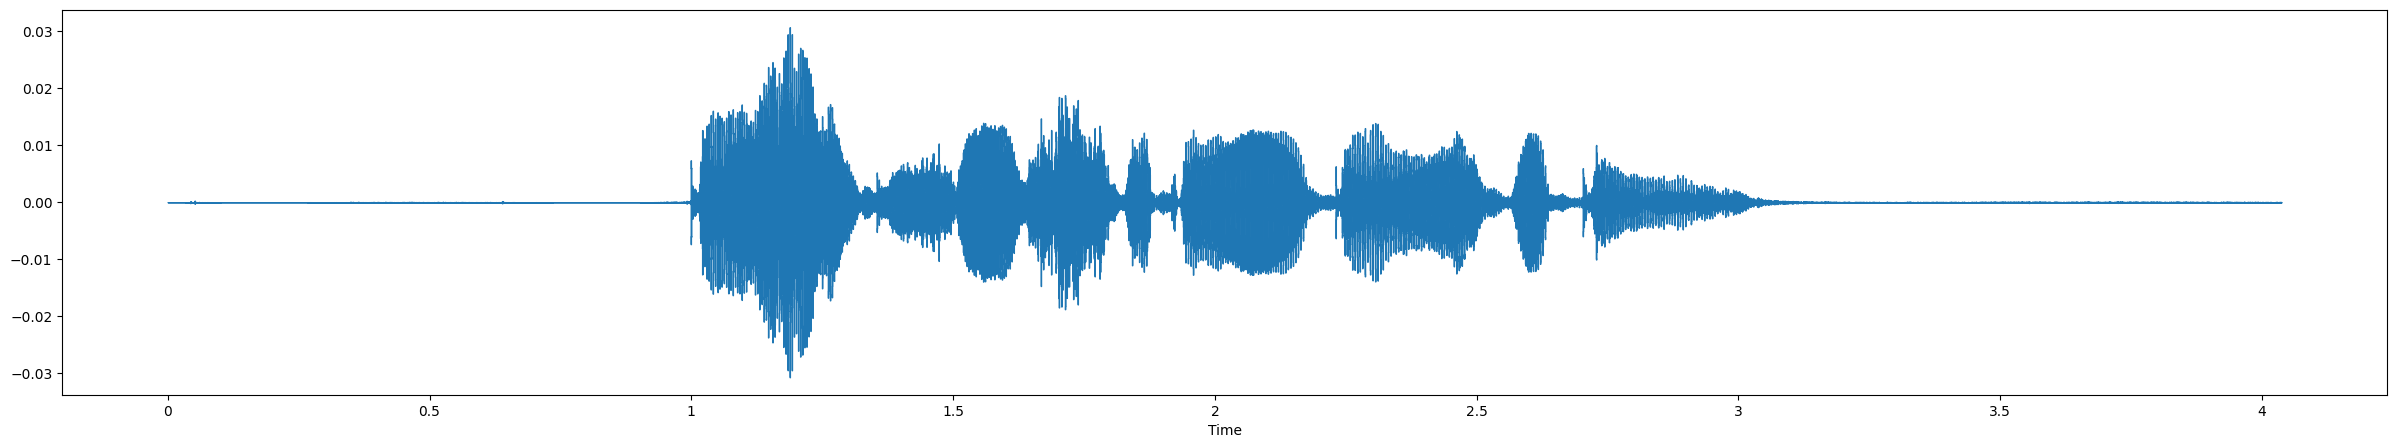

In [9]:
#plot the waveform of the example with librosa
figure = plt.figure(figsize=(30, 5))
librosa.display.waveshow(audio, sr=sr)

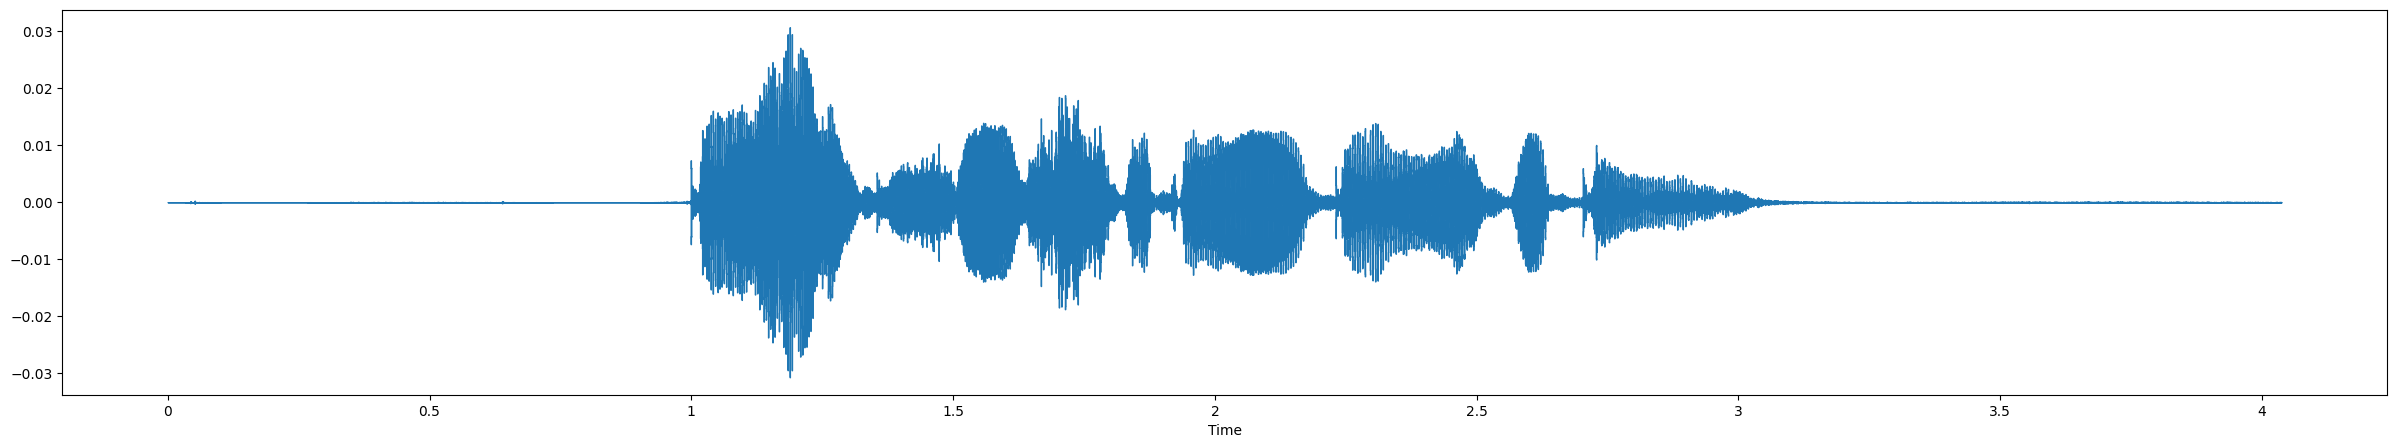

In [10]:
#now we have to convert the audio signal in the MEL scale. We choose the MEL
#scale instead of the MFCC because the second represents the waveforms with less
#value and less correlation but also less performance
y, _ = librosa.effects.trim(audio) # Trim leading and trailing silence from an audio signal
audio = y
figure = plt.figure(figsize=(30, 5))
librosa.display.waveshow(audio, sr=sr)

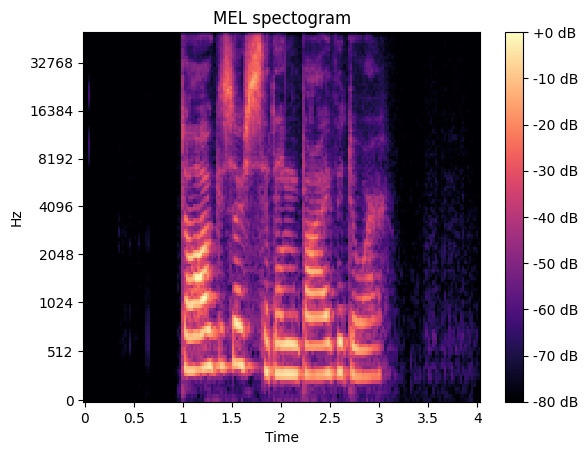

In [11]:
audio_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=1024, hop_length= 512)

fig, ax = plt.subplots()

audio_db = librosa.power_to_db(audio_spec, ref=np.max)
img = librosa.display.specshow(audio_db, x_axis='time', y_axis='mel', sr=sr, fmax=50000)
ax.set_title('MEL spectogram')
fig.colorbar(img, format='%+2.0f dB')

In [12]:
#Dictionary with emotions
dicts = {'01':'neutral', '02':'calm', '03':'happy', '04':'sad', '05':'angry', '06':'fearful', '07':'disgust', '08':'surprised'}

Berfore creating the neural network, we have to organise the folder in the right way: 8 folder, each one with the name of the emotion, instead of the 24 folders with the number of the actors

In [13]:
import re
!ls
%cd /content/drive/MyDrive/Tesi/
path_main='RAVDESS'
folders_main=os.listdir(path_main)
print(folders_main)

Actor_01  Actor_04  Actor_07  Actor_10	Actor_13  Actor_16  Actor_19  Actor_22
Actor_02  Actor_05  Actor_08  Actor_11	Actor_14  Actor_17  Actor_20  Actor_23
Actor_03  Actor_06  Actor_09  Actor_12	Actor_15  Actor_18  Actor_21  Actor_24
/content/drive/MyDrive/Tesi
['Actor_07', 'Actor_01', 'Actor_08', 'Actor_22', 'Actor_06', 'Actor_23', 'Actor_09', 'Actor_14', 'Actor_24', 'Actor_13', 'Actor_05', 'Actor_19', 'Actor_03', 'Actor_12', 'Actor_02', 'Actor_04', 'Actor_15', 'Actor_21', 'Actor_10', 'Actor_17', 'Actor_11', 'Actor_16', 'Actor_18', 'Actor_20']


Il codice accedere a tutte le sotto cartelle di RAVDESS e per ogni file, inserisce i numeri del nome nelle array numbers di cui il terzo elemento (numbers[2]) individua l'emozione dell'audio. Fatto questo si ricerca l'emozione nel dizionario e si ricostruisce il percorso alla nuova directori

In [14]:
def is_folder_empty(folder_path):
    # retrive the list of the objects in the directory
    contents = os.listdir(folder_path)

    if len(contents) == 0:
        return True
    else:
        return False

folder_path = '/content/drive/MyDrive/Tesi/sorted_data_ravdess/happy'

#check if the folder is empty
if is_folder_empty(folder_path):
    for folders in folders_main :
        path_in = os.path.join('RAVDESS', folders)
        files_sub=os.listdir(path_in)

        for file in files_sub :
            file_name_without_extension = os.path.splitext(file)[0]
            numbers = re.findall('\d+',file_name_without_extension)
            emotion=dicts[numbers[2]]
            path_save = os.path.join('sorted_data_ravdess', emotion,f"{file_name_without_extension}.jpeg")
            path_load = os.path.join(path_in, file)
            y, sr = librosa.load(path_load)
            yt, _ = librosa.effects.trim(y)
            y = yt
            mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)
            mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time')
            plt.axis('off')
            plt.savefig(path_save)
            plt.close()

In [15]:
batch_size = 32
img_height = 180
img_width = 180

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Tesi/sorted_data_ravdess',
    validation_split=0.2,
    subset="both",
    seed=2001,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 1440 files belonging to 8 classes.
Using 1152 files for training.
Using 288 files for validation.


In [16]:
import numpy as np
train_ds_iterator = train_ds.as_numpy_iterator() # it is an iterator on the training dataset
batch = train_ds_iterator.next()
print(batch[0].shape) #the number of images from batch, it should correspond to the ones specified in the keras.utilis.image_dataset_from_directory

(32, 180, 180, 3)


(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)


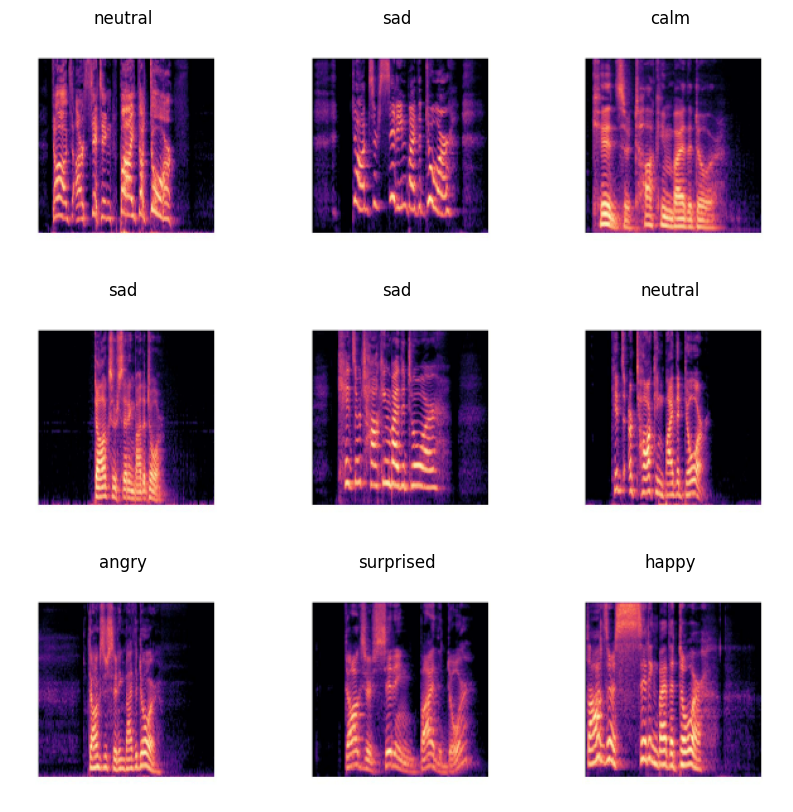

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        print(images[i].shape)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(dicts['0' + str(int(labels[i])+1)])
        plt.axis("off")

In [18]:
#all class names
class_names = train_ds.class_names
print(class_names)

['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [19]:
#example of some elements in the dataset
for image, label in train_ds.take(5):
    print("Shape of the image:", image.shape)
    print("label of the image:", label)
    print("Type of the image:", image.dtype)
    print()


Shape of the image: (32, 180, 180, 3)
label of the image: tf.Tensor([7 2 2 0 5 7 7 4 3 2 2 2 1 4 3 6 2 6 2 2 7 7 3 6 4 5 3 3 4 2 1 6], shape=(32,), dtype=int32)
Type of the image: <dtype: 'float32'>

Shape of the image: (32, 180, 180, 3)
label of the image: tf.Tensor([6 4 6 7 7 6 6 4 6 6 6 2 6 0 5 7 4 1 4 1 0 4 4 4 2 5 2 2 3 7 0 3], shape=(32,), dtype=int32)
Type of the image: <dtype: 'float32'>

Shape of the image: (32, 180, 180, 3)
label of the image: tf.Tensor([7 5 3 3 0 6 3 7 0 2 6 4 7 3 5 4 1 3 0 0 5 3 6 7 0 7 4 2 5 7 4 7], shape=(32,), dtype=int32)
Type of the image: <dtype: 'float32'>

Shape of the image: (32, 180, 180, 3)
label of the image: tf.Tensor([7 1 2 1 3 6 6 2 6 1 5 5 1 2 4 3 1 5 4 3 4 4 5 1 7 6 7 0 3 3 1 0], shape=(32,), dtype=int32)
Type of the image: <dtype: 'float32'>

Shape of the image: (32, 180, 180, 3)
label of the image: tf.Tensor([4 1 1 0 7 0 6 2 7 2 0 2 7 4 5 6 0 1 0 1 2 3 3 3 5 4 3 6 6 2 7 5], shape=(32,), dtype=int32)
Type of the image: <dtype: 'float32'>



In [20]:
#data augmentation
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [21]:
#normalization of the datasets
train_ds = train_ds.map(lambda x,y: (x/255, y))
val_ds = val_ds.map(lambda x,y: (x/255, y))
print(train_ds.as_numpy_iterator().next()[0].min()) # we check for instance the min
print(train_ds.as_numpy_iterator().next()[0].max()) # we check for instance the max

0.0
1.0


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']       

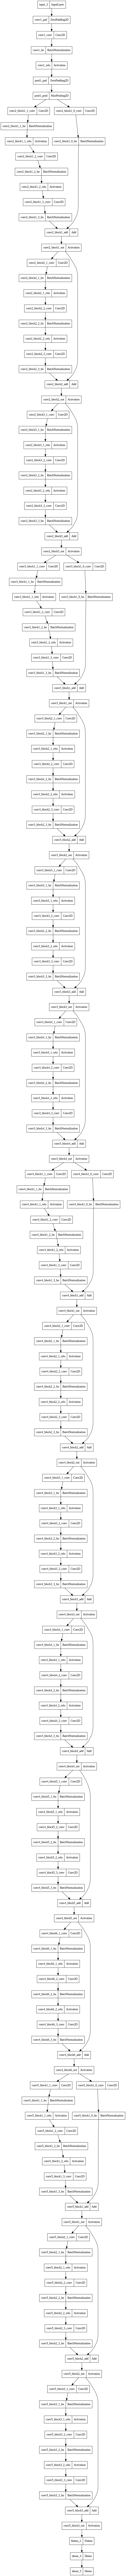

In [24]:
from keras.applications import ResNet50
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam

# shape of the images
input_shape = (180, 180, 3)

# load the ResNet50 pre-trained network with the imagenet weights
# include_top = False doesn't include the classofocation layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# add the last layers
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)

# create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# freeze the weights of the VGG16 network to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#final summary
model.summary()
tf.keras.utils.plot_model(model)

In [25]:
epochs = 20

logdir='logs_ResNet50'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) # it allows to create the checkpoint to check the log, to save a tmp model, to see how your model is performing


# fit the data
hist = model.fit(
    train_ds, # training data
    epochs=epochs, # how long to train
    validation_data=val_ds, # we pass then the validation, we can see how the model performs in real time
    callbacks=[tensorboard_callback] # pass the callback for the checkpoint
)


Epoch 1/20
36/36 [==============================] - 265s 7s/step - loss: 4.0653 - accuracy: 0.1415 - val_loss: 2.2176 - val_accuracy: 0.1389
Epoch 2/20
36/36 [==============================] - 263s 7s/step - loss: 2.1088 - accuracy: 0.2118 - val_loss: 2.1172 - val_accuracy: 0.1701
Epoch 3/20
36/36 [==============================] - 224s 6s/step - loss: 2.1349 - accuracy: 0.2222 - val_loss: 2.0473 - val_accuracy: 0.2500
Epoch 4/20
36/36 [==============================] - 260s 7s/step - loss: 2.0158 - accuracy: 0.2326 - val_loss: 2.1481 - val_accuracy: 0.2083
Epoch 5/20
36/36 [==============================] - 264s 7s/step - loss: 2.1601 - accuracy: 0.2431 - val_loss: 1.8243 - val_accuracy: 0.2812
Epoch 6/20
36/36 [==============================] - 223s 6s/step - loss: 1.9949 - accuracy: 0.2691 - val_loss: 1.9986 - val_accuracy: 0.1910
Epoch 7/20
36/36 [==============================] - 222s 6s/step - loss: 2.0561 - accuracy: 0.2370 - val_loss: 2.0295 - val_accuracy: 0.2882
Epoch 8/20
36

In [26]:
import json
# now we want to save the model
model.save(os.path.join('/content/drive/MyDrive/Tesi/ResNet50', 'ResNet50.h5'))
# we need to save history object for further analysis
hist_path = os.path.join('/content/drive/MyDrive/Tesi/ResNet50', 'ResNet50_history.json')
with open(hist_path, 'w') as f:
    json.dump(hist.history, f)